## Importing required libraries for project

In [16]:
import pandas as pd
import numpy as np
from dateutil import parser
from datetime import datetime, timedelta
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Loading data set

In [17]:
df=pd.read_csv("../data/raw/weather_raw.csv")

## Displaying data frame first 5 rows

In [18]:
df.head()

,weather_id,date_time,city,season,temperature_c,humidity,rain_mm,weather_condition,wind_speed_kmh,visibility_m,air_pressure_hpa
0,5001.0,2024-01-01 00:00,London,Winter,-2.21,-34.25507,NaN,Snow,43.60,875,1010.73
1,5002.0,2024-01-01 02:00,London,Winter,14.46,80.00000,NaN,Clear,78.82,9857,1004.81
2,5003.0,2024-01-01 04:00,London,Winter,4.25,84.00000,0.0,Snow,21.42,9620,996.09
3,5004.0,2024-01-01 06:00,London,NaN,1.41,74.00000,0.0,Clear,54.42,11148,1007.39
4,NaN,2024-01-01 08:00,London,Winter,7.51,52.00000,0.0,Clear,NaN,11599,999.58


## Displaying data frame last 5 rows

In [19]:
df.tail()

,weather_id,date_time,city,season,temperature_c,humidity,rain_mm,weather_condition,wind_speed_kmh,visibility_m,air_pressure_hpa
5245,6832.0,2024-06-01 14:00,London,Summer,23.620000,36.000000,0.0,NaN,28.44,11626,1014.100000
5246,7179.0,30/06/2024 12PM,NaN,Summer,27.520000,-30.133577,0.0,Clear,31.88,11102,1029.740000
5247,6418.0,NaN,London,Autumn,10.860000,65.000000,NaN,Clear,4.96,120017.40781960126,896.555073
5248,6783.0,2024-05-28T12:00Z,London,Spring,6.620000,70.000000,0.0,Clear,18.76,NaN,1003.470000
5249,9716.0,2025-01-27T22:00Z,London,Winter,69.903142,41.000000,0.0,Clear,22.59,11257,1008.680000


## Displaying data frame:
### a) column names
### b) Number of non-null rows
### c) Data type of each column
### d) memory usage

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5250 entries, 0 to 5249
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   weather_id         4747 non-null   float64
 1   date_time          4701 non-null   object 
 2   city               4724 non-null   object 
 3   season             4710 non-null   object 
 4   temperature_c      4704 non-null   float64
 5   humidity           4758 non-null   float64
 6   rain_mm            4708 non-null   float64
 7   weather_condition  4727 non-null   object 
 8   wind_speed_kmh     4694 non-null   float64
 9   visibility_m       4712 non-null   object 
 10  air_pressure_hpa   4742 non-null   float64
dtypes: float64(6), object(5)
memory usage: 451.3+ KB


## Displaying some statistics about numerical features in data set

In [21]:
df.describe()

,weather_id,temperature_c,humidity,rain_mm,wind_speed_kmh,air_pressure_hpa
count,4747.000000,4704.000000,4758.000000,4708.000000,4694.000000,4742.000000
mean,7497.157784,12.731986,61.300459,20.587207,62.586867,1005.869145
std,1445.085614,20.566399,33.836190,52.211265,76.187902,37.739979
min,5001.000000,-54.816060,-34.860546,0.000000,0.010000,875.075387
25%,6250.500000,6.467500,44.000000,0.000000,21.992500,994.932500
50%,7488.000000,12.740000,61.000000,0.000000,45.475000,1007.615000
75%,8746.500000,19.520000,76.000000,7.942500,66.745000,1019.677500
max,10000.000000,84.774651,174.913655,224.874578,374.852909,1124.978764


# (1) Data Cleaning

# Cleaning order:
## 1. Handling nulls (missing values)
## 2. Adjusting columns data types (formats)
## 3. Removing duplicated rows
## 4. Handling outliers

# <hr style="height:3px; border:none; background:#4a90e2;">

# <div style="background:#f2f2f2; padding:12px; border-left:5px solid #4a90e2;">
#  <h3>📌 1. Handling nulls (missing values) </h3>
# </div>

# <hr style="height:3px; border:none; background:#4a90e2;">

## a) Pattern Based cleaning

## I- Problems in "weather_id" column:
###  503 rows in "weather_id" column have null values
###  448 rows in "weather_id" column with duplicated values

# <hr style="height:3px; border:none; background:#4a90e2;">

## Function goal:
### Set duplicated weather_id as nulls/missing values (with keeping weather_id first occurrence)
### Impute each missing value (even original null or resulted from setting duplicated id as null) with value of :
### [weather_id directly before this null + 1] , as this column follows a pattern

In [22]:
def clean_weather_id(df):

    # Create a copy to avoid modifying the original
    df_cleaned = df.copy()
    
    # Step 1: Mark duplicates as NaN (keep first occurrence)
    duplicates_mask = df_cleaned['weather_id'].duplicated(keep='first')
    df_cleaned.loc[duplicates_mask, 'weather_id'] = np.nan
    
    # Step 2: Impute all NaN values with previous id + 1
    for i in range(len(df_cleaned)):
        if pd.isna(df_cleaned.loc[i, 'weather_id']):
            if i == 0:
                # If first row is NaN, start with 1 (or 0, depending on your preference)
                df_cleaned.loc[i, 'weather_id'] = 1
            else:
                # Use previous id + 1
                df_cleaned.loc[i, 'weather_id'] = df_cleaned.loc[i-1, 'weather_id'] + 1
    
    # Step 3: Convert to integer type
    df_cleaned['weather_id'] = df_cleaned['weather_id'].astype(int)
    
    return df_cleaned

## Displaying data set after cleaning weather_id column from nulls

In [23]:
df_stage_1=clean_weather_id(df)
df_stage_1

,weather_id,date_time,city,season,temperature_c,humidity,rain_mm,weather_condition,wind_speed_kmh,visibility_m,air_pressure_hpa
0,5001,2024-01-01 00:00,London,Winter,-2.210000,-34.255070,NaN,Snow,43.60,875,1010.730000
1,5002,2024-01-01 02:00,London,Winter,14.460000,80.000000,NaN,Clear,78.82,9857,1004.810000
2,5003,2024-01-01 04:00,London,Winter,4.250000,84.000000,0.0,Snow,21.42,9620,996.090000
3,5004,2024-01-01 06:00,London,NaN,1.410000,74.000000,0.0,Clear,54.42,11148,1007.390000
4,5005,2024-01-01 08:00,London,Winter,7.510000,52.000000,0.0,Clear,NaN,11599,999.580000
...,...,...,...,...,...,...,...,...,...,...,...
5245,10246,2024-06-01 14:00,London,Summer,23.620000,36.000000,0.0,NaN,28.44,11626,1014.100000
5246,10247,30/06/2024 12PM,NaN,Summer,27.520000,-30.133577,0.0,Clear,31.88,11102,1029.740000
5247,10248,NaN,London,Autumn,10.860000,65.000000,NaN,Clear,4.96,120017.40781960126,896.555073
5248,10249,2024-05-28T12:00Z,London,Spring,6.620000,70.000000,0.0,Clear,18.76,NaN,1003.470000


# II- Problems in "city" column:
## 526 rows in "city" column have null values

## Function goal:
### Impute each null/missing value by "London" value [as this column has only 1 value which is london]

In [24]:
def clean_city(df):
    
    # Create a copy to avoid modifying the original
    df_cleaned = df.copy()
    
    # Impute null values with "London"
    df_cleaned['city'] = df_cleaned['city'].fillna('London')
    
    return df_cleaned

## Displaying data set after cleaning city column from nulls

In [25]:
df_stage_2=clean_city(df_stage_1)
df_stage_2

,weather_id,date_time,city,season,temperature_c,humidity,rain_mm,weather_condition,wind_speed_kmh,visibility_m,air_pressure_hpa
0,5001,2024-01-01 00:00,London,Winter,-2.210000,-34.255070,NaN,Snow,43.60,875,1010.730000
1,5002,2024-01-01 02:00,London,Winter,14.460000,80.000000,NaN,Clear,78.82,9857,1004.810000
2,5003,2024-01-01 04:00,London,Winter,4.250000,84.000000,0.0,Snow,21.42,9620,996.090000
3,5004,2024-01-01 06:00,London,NaN,1.410000,74.000000,0.0,Clear,54.42,11148,1007.390000
4,5005,2024-01-01 08:00,London,Winter,7.510000,52.000000,0.0,Clear,NaN,11599,999.580000
...,...,...,...,...,...,...,...,...,...,...,...
5245,10246,2024-06-01 14:00,London,Summer,23.620000,36.000000,0.0,NaN,28.44,11626,1014.100000
5246,10247,30/06/2024 12PM,London,Summer,27.520000,-30.133577,0.0,Clear,31.88,11102,1029.740000
5247,10248,NaN,London,Autumn,10.860000,65.000000,NaN,Clear,4.96,120017.40781960126,896.555073
5248,10249,2024-05-28T12:00Z,London,Spring,6.620000,70.000000,0.0,Clear,18.76,NaN,1003.470000


## III- Problems in "date_time" column:
### 3133 rows have inconsistent date format ex:
### 2024-01-01T10:00Z (ISO format of date)
### 02/01/2024 06AM (12-hour format date)
### 553 rows in "date_time" column are duplicated
###  549 rows in "date_time" column are directly null values
###  25 rows in "date_time" column have "TBD" (To Be Determined) values
###  15 rows in "date_time" column have "Unknown" values
###  13 rows in "date_time" column have wrong values , ex: 2099-13-40 25:61 

# <hr style="height:3px; border:none; background:#4a90e2;">

## Function goal:
### Unify the format of all dates into the standard date format which is:
###  "YYYY-MM-DD HH:MM"  --> ex: 2024-01-15 08:00
### Set 25 rows of "TBD" values into missing values
### Set 15 rows of "Unknown" values into missing values
### Set 13 rows of wrong date values into into missing values

In [26]:
def clean_date_time_part_1(df):

    # Create a copy to avoid modifying the original
    df_cleaned = df.copy()
    
    # Step a & b: Replace "TBD" and "Unknown" with NaN
    df_cleaned['date_time'] = df_cleaned['date_time'].replace(['TBD', 'Unknown'], np.nan)
    
    # Step c & d: Parse and validate dates, set invalid ones to NaN
    def parse_and_format_date(date_str):
        if pd.isna(date_str):
            return np.nan
        
        try:
            # Convert to string if not already
            date_str = str(date_str).strip()
            
            # Try to parse the date using dateutil parser (handles multiple formats)
            parsed_date = parser.parse(date_str, dayfirst=False)
            
            # Validate the parsed date (check for logical values)
            if (parsed_date.year < 1900 or parsed_date.year > 2100 or
                parsed_date.month < 1 or parsed_date.month > 12 or
                parsed_date.day < 1 or parsed_date.day > 31 or
                parsed_date.hour < 0 or parsed_date.hour > 23 or
                parsed_date.minute < 0 or parsed_date.minute > 59):
                return np.nan
            
            # Format to "YYYY-MM-DD HH:MM"
            return parsed_date.strftime("%Y-%m-%d %H:%M")
        
        except (ValueError, parser.ParserError):
            # If parsing fails, return NaN
            return np.nan
    
    # Apply the parsing function to each row
    df_cleaned['date_time'] = df_cleaned['date_time'].apply(parse_and_format_date)
    
    return df_cleaned

## Display data set after cleaning date_time column from nulls [Partially]

In [27]:
df_stage_3=clean_date_time_part_1(df_stage_2)
df_stage_3

,weather_id,date_time,city,season,temperature_c,humidity,rain_mm,weather_condition,wind_speed_kmh,visibility_m,air_pressure_hpa
0,5001,2024-01-01 00:00,London,Winter,-2.210000,-34.255070,NaN,Snow,43.60,875,1010.730000
1,5002,2024-01-01 02:00,London,Winter,14.460000,80.000000,NaN,Clear,78.82,9857,1004.810000
2,5003,2024-01-01 04:00,London,Winter,4.250000,84.000000,0.0,Snow,21.42,9620,996.090000
3,5004,2024-01-01 06:00,London,NaN,1.410000,74.000000,0.0,Clear,54.42,11148,1007.390000
4,5005,2024-01-01 08:00,London,Winter,7.510000,52.000000,0.0,Clear,NaN,11599,999.580000
...,...,...,...,...,...,...,...,...,...,...,...
5245,10246,2024-06-01 14:00,London,Summer,23.620000,36.000000,0.0,NaN,28.44,11626,1014.100000
5246,10247,2024-06-30 12:00,London,Summer,27.520000,-30.133577,0.0,Clear,31.88,11102,1029.740000
5247,10248,NaN,London,Autumn,10.860000,65.000000,NaN,Clear,4.96,120017.40781960126,896.555073
5248,10249,2024-05-28 12:00,London,Spring,6.620000,70.000000,0.0,Clear,18.76,NaN,1003.470000


## Function goal:
### Remove duplicated dates (keep first occurrence only)
### Impute nulls (whether these values are originalyy nulls or resulted from setting Unknown values & TBD values * wrong dates by nulls)

# <hr style="height:3px; border:none; background:#4a90e2;">

## Imputation strategy:
### Each day in data set has 12 dates , as weather measurement is taken for each day every 2 hours
### function will get both first date and last date in this column
### it will generate list of dates for all days between first date (included) and last date (included) , where also each day has 12 dates
### if there is a missing value , function will get its corresponding date in the generated dates list
### function will sort dates in the column in as ascending order after cleaning

In [28]:
def clean_date_time_part_2(df):
 
    # Create a copy to avoid modifying the original
    df_cleaned = df.copy()
    
    # Step a: Remove duplicates (set duplicates to NaN, keep first)
    # Convert to datetime for comparison
    df_cleaned['date_time_parsed'] = pd.to_datetime(df_cleaned['date_time'], 
                                                      format='%Y-%m-%d %H:%M', 
                                                      errors='coerce')
    
    # Mark duplicates as NaN
    duplicates_mask = df_cleaned['date_time_parsed'].duplicated(keep='first')
    df_cleaned.loc[duplicates_mask, 'date_time'] = np.nan
    df_cleaned.loc[duplicates_mask, 'date_time_parsed'] = pd.NaT
    
    # Step b: Get min and max dates (from non-null values)
    valid_dates = df_cleaned['date_time_parsed'].dropna()
    
    if len(valid_dates) == 0:
        # If no valid dates, return as is
        df_cleaned.drop('date_time_parsed', axis=1, inplace=True)
        return df_cleaned
    
    min_date = valid_dates.min()
    max_date = valid_dates.max()
    
    # Step c & d: Generate expected dates at 2-hour intervals
    # Set min_date to start of day at 00:00
    min_date = min_date.replace(hour=0, minute=0, second=0, microsecond=0)
    # Set max_date to end of day at 22:00
    max_date = max_date.replace(hour=22, minute=0, second=0, microsecond=0)
    
    # Generate all expected dates
    generated_dates = []
    current_date = min_date
    while current_date <= max_date:
        generated_dates.append(current_date)
        current_date += timedelta(hours=2)
    
    # Step e: Impute missing values with generated dates
    # Create a set of existing dates for quick lookup
    existing_dates_set = set(df_cleaned['date_time_parsed'].dropna())
    
    # Create a list of available generated dates (not already used)
    available_dates = [d for d in generated_dates if d not in existing_dates_set]
    
    # Fill nulls with available dates sequentially
    available_index = 0
    for i in range(len(df_cleaned)):
        if pd.isna(df_cleaned.loc[i, 'date_time']):
            if available_index < len(available_dates):
                df_cleaned.loc[i, 'date_time'] = available_dates[available_index].strftime('%Y-%m-%d %H:%M')
                available_index += 1
            else:
                # If we run out of generated dates, continue the pattern
                if len(generated_dates) > 0:
                    last_date = generated_dates[-1] + timedelta(hours=2 * (available_index - len(available_dates) + 1))
                    df_cleaned.loc[i, 'date_time'] = last_date.strftime('%Y-%m-%d %H:%M')
                    available_index += 1
    
    # Drop the temporary parsed column
    df_cleaned.drop('date_time_parsed', axis=1, inplace=True)
    
    # Final step: Sort by date_time from smallest to largest
    df_cleaned['date_time_temp'] = pd.to_datetime(df_cleaned['date_time'], 
                                                    format='%Y-%m-%d %H:%M', 
                                                    errors='coerce')
    df_cleaned = df_cleaned.sort_values('date_time_temp').reset_index(drop=True)
    df_cleaned.drop('date_time_temp', axis=1, inplace=True)
    
    return df_cleaned


## Displaying data set after cleaning date_time column from nulls [totally]

In [29]:
df_stage_4=clean_date_time_part_2(df_stage_3)
df_stage_4

,weather_id,date_time,city,season,temperature_c,humidity,rain_mm,weather_condition,wind_speed_kmh,visibility_m,air_pressure_hpa
0,5001,2024-01-01 00:00,London,Winter,-2.210000,-34.255070,NaN,Snow,43.60000,875,1010.73
1,5002,2024-01-01 02:00,London,Winter,14.460000,80.000000,NaN,Clear,78.82000,9857,1004.81
2,5003,2024-01-01 04:00,London,Winter,4.250000,84.000000,0.00,Snow,21.42000,9620,996.09
3,5004,2024-01-01 06:00,London,NaN,1.410000,74.000000,0.00,Clear,54.42000,11148,1007.39
4,5005,2024-01-01 08:00,London,Winter,7.510000,52.000000,0.00,Clear,NaN,11599,999.58
...,...,...,...,...,...,...,...,...,...,...,...
5245,9531,2025-12-01 12:00,London,Winter,NaN,62.000000,NaN,Clear,361.61383,8453,1022.76
5246,9532,2025-12-01 14:00,London,NaN,-43.519154,29.000000,0.00,NaN,52.21000,10410,1023.47
5247,9534,2025-12-01 18:00,London,Winter,-3.110000,-19.809542,0.00,Snow,70.33000,NaN,1016.45
5248,9902,2025-12-02 10:00,London,Winter,3.550000,69.000000,4.44,Fog,29.76000,NaN,1015.67


## IV- Problems in "season" column:
### 540 rows in it are missing values (nulls)
### in consistent seasons with respect to its corresponding date_time column value
### ex: 25/01/2024 is Summer season

# <hr style="height:3px; border:none; background:#4a90e2;">

## Imputation strategy:
### i'll follow Meteorological Seasons rules (which depend on "date_time" column) to fill nulls also to avoid wrong values , which are:
### if date time is between "YYYY-03-01 00:00" and "YYYY-05-31 23:59" then season is "Spring" 
### [from March 1 to May 31]
### if date time is between "YYYY-06-01 00:00" and "YYYY-08-31 23:59" then season is "Summer" 
### [from June 1 to August 31]
### if date time is between "YYYY-09-01 00:00" and "YYYY-11-30 23:59" then season is "Autumn"
### [from September 1 to November 30]
### if date time is between "YYYY-12-01 00:00" and "YYYY+1-02-28 23:59" or "YYYY+1-02-29 23:59" then season is "Winter" [from December 1 to February 28 or Feb 29]

In [31]:
def clean_season(df):

    # Create a copy to avoid modifying the original
    df_cleaned = df.copy()
    
    # Convert date_time to datetime for processing
    df_cleaned['date_time_parsed'] = pd.to_datetime(df_cleaned['date_time'], 
                                                      format='%Y-%m-%d %H:%M', 
                                                      errors='coerce')
    
    # Function to determine season based on date
    def get_season(date):
        if pd.isna(date):
            return np.nan
        
        month = date.month
        
        if 3 <= month <= 5:
            return 'Spring'
        elif 6 <= month <= 8:
            return 'Summer'
        elif 9 <= month <= 11:
            return 'Autumn'
        else:  # month in [12, 1, 2]
            return 'Winter'
    
    # Apply the season determination to all rows
    df_cleaned['season'] = df_cleaned['date_time_parsed'].apply(get_season)
    
    # Drop the temporary parsed column
    df_cleaned.drop('date_time_parsed', axis=1, inplace=True)
    
    return df_cleaned

## Displaying data set after cleaning season column from nulls

In [32]:
df_stage_5=clean_season(df_stage_4)
df_stage_5

,weather_id,date_time,city,season,temperature_c,humidity,rain_mm,weather_condition,wind_speed_kmh,visibility_m,air_pressure_hpa
0,5001,2024-01-01 00:00,London,Winter,-2.210000,-34.255070,NaN,Snow,43.60000,875,1010.73
1,5002,2024-01-01 02:00,London,Winter,14.460000,80.000000,NaN,Clear,78.82000,9857,1004.81
2,5003,2024-01-01 04:00,London,Winter,4.250000,84.000000,0.00,Snow,21.42000,9620,996.09
3,5004,2024-01-01 06:00,London,Winter,1.410000,74.000000,0.00,Clear,54.42000,11148,1007.39
4,5005,2024-01-01 08:00,London,Winter,7.510000,52.000000,0.00,Clear,NaN,11599,999.58
...,...,...,...,...,...,...,...,...,...,...,...
5245,9531,2025-12-01 12:00,London,Winter,NaN,62.000000,NaN,Clear,361.61383,8453,1022.76
5246,9532,2025-12-01 14:00,London,Winter,-43.519154,29.000000,0.00,NaN,52.21000,10410,1023.47
5247,9534,2025-12-01 18:00,London,Winter,-3.110000,-19.809542,0.00,Snow,70.33000,NaN,1016.45
5248,9902,2025-12-02 10:00,London,Winter,3.550000,69.000000,4.44,Fog,29.76000,NaN,1015.67


## V- Problems in "weather_condition" column:
### 523 rows in "weather_condition" column are with null values

# <hr style="height:3px; border:none; background:#4a90e2;">

## Imputation strategy:
### find mode weather_condition value of each season 
### replace each blank cell / null value in weather_condition column with the mode weather_condition value of its corresponding season

In [33]:
def clean_weather_condition(df):
    
    # Create a copy to avoid modifying the original dataframe
    df_clean = df.copy()
    
    # a) Set empty cells as nulls
    # Convert empty strings and whitespace-only strings to NaN
    df_clean['weather_condition'] = df_clean['weather_condition'].replace(r'^\s*$', np.nan, regex=True)
    
    # b) Find and display the most repeated weather_condition for each season
    print("Most common weather condition for each season:")
    print("-" * 50)
    
    season_modes = {}
    
    for season in sorted(df_clean['season'].unique()):
        # Get non-null weather conditions for this season
        season_data = df_clean.loc[
            (df_clean['season'] == season) & 
            (df_clean['weather_condition'].notna()), 
            'weather_condition'
        ]
        
        if not season_data.empty:
            # Calculate value counts
            value_counts = season_data.value_counts()
            mode_value = value_counts.index[0] if len(value_counts) > 0 else None
            mode_count = value_counts.iloc[0] if len(value_counts) > 0 else 0
            
            # Store for later use
            season_modes[season] = mode_value
            
            # Display detailed information
            print(f"Season: {season}")
            print(f"  Most common: '{mode_value}' (appears {mode_count} times)")
            
            # Show top 3 if available
            if len(value_counts) > 1:
                print(f"  Top 3 weather conditions:")
                for i in range(min(3, len(value_counts))):
                    print(f"    {i+1}. '{value_counts.index[i]}': {value_counts.iloc[i]} occurrences")
            print()
        else:
            season_modes[season] = None
            print(f"Season: {season}")
            print(f"  No non-null weather condition data available")
            print()
    
    print("-" * 50)
    
    # Count and display null values before imputation
    null_count_before = df_clean['weather_condition'].isna().sum()
    print(f"\nNull values before imputation: {null_count_before}")
    
    if null_count_before > 0:
        print("\nNull value distribution by season before imputation:")
        null_by_season = df_clean[df_clean['weather_condition'].isna()]['season'].value_counts()
        for season, count in null_by_season.items():
            print(f"  {season}: {count} nulls")
    
    # c) Replace nulls with the mode of corresponding season
    def fill_null_with_season_mode(row):
        if pd.isna(row['weather_condition']) and row['season'] in season_modes:
            return season_modes[row['season']]
        return row['weather_condition']
    
    df_clean['weather_condition'] = df_clean.apply(fill_null_with_season_mode, axis=1)
    
    # Count and display null values after imputation
    null_count_after = df_clean['weather_condition'].isna().sum()
    print(f"\nNull values after imputation: {null_count_after}")
    
    if null_count_after > 0:
        print("Note: Some nulls remain because their season had no non-null weather conditions")
    
    return df_clean

## Displaying most repeated weather condition for each season in the data set

In [34]:
df_stage_6=clean_weather_condition(df_stage_5)

Most common weather condition for each season:
--------------------------------------------------
Season: Autumn
  Most common: 'Clear' (appears 664 times)
  Top 3 weather conditions:
    1. 'Clear': 664 occurrences
    2. 'Rain': 134 occurrences
    3. 'Fog': 91 occurrences

Season: Spring
  Most common: 'Clear' (appears 767 times)
  Top 3 weather conditions:
    1. 'Clear': 767 occurrences
    2. 'Rain': 105 occurrences
    3. 'Fog': 97 occurrences

Season: Summer
  Most common: 'Clear' (appears 769 times)
  Top 3 weather conditions:
    1. 'Clear': 769 occurrences
    2. 'Fog': 85 occurrences
    3. 'Rain': 74 occurrences

Season: Winter
  Most common: 'Clear' (appears 1009 times)
  Top 3 weather conditions:
    1. 'Clear': 1009 occurrences
    2. 'Snow': 239 occurrences
    3. 'Rain': 151 occurrences

--------------------------------------------------

Null values before imputation: 523

Null value distribution by season before imputation:
  Winter: 181 nulls
  Spring: 130 nulls
  

## Displaying data set after cleaning weather condition column from nulls

In [35]:
df_stage_6

,weather_id,date_time,city,season,temperature_c,humidity,rain_mm,weather_condition,wind_speed_kmh,visibility_m,air_pressure_hpa
0,5001,2024-01-01 00:00,London,Winter,-2.210000,-34.255070,NaN,Snow,43.60000,875,1010.73
1,5002,2024-01-01 02:00,London,Winter,14.460000,80.000000,NaN,Clear,78.82000,9857,1004.81
2,5003,2024-01-01 04:00,London,Winter,4.250000,84.000000,0.00,Snow,21.42000,9620,996.09
3,5004,2024-01-01 06:00,London,Winter,1.410000,74.000000,0.00,Clear,54.42000,11148,1007.39
4,5005,2024-01-01 08:00,London,Winter,7.510000,52.000000,0.00,Clear,NaN,11599,999.58
...,...,...,...,...,...,...,...,...,...,...,...
5245,9531,2025-12-01 12:00,London,Winter,NaN,62.000000,NaN,Clear,361.61383,8453,1022.76
5246,9532,2025-12-01 14:00,London,Winter,-43.519154,29.000000,0.00,Clear,52.21000,10410,1023.47
5247,9534,2025-12-01 18:00,London,Winter,-3.110000,-19.809542,0.00,Snow,70.33000,NaN,1016.45
5248,9902,2025-12-02 10:00,London,Winter,3.550000,69.000000,4.44,Fog,29.76000,NaN,1015.67


 
# <div style="background:#f2f2f2; padding:12px; border-left:5px solid #4a90e2;">
#  <h3>📌 2. Adjusting columns data types (formats) </h3>
# </div>

# <hr style="height:3px; border:none; background:#4a90e2;">

# Problems:
## a) date_time column data type is object => it must be datetime
## b) visibility_m column:
### i- data type is object => it should be float
### ii- 16 rows have "???" as value
### iii- 299 rows are missing values (nulls)
### iv- 18 rows have "N/A" as a value => will be set as missing value to facilitate the column data type adjusting process
### v- 19 rows have "error" as a value => will be set as missing value to facilitate the column data type adjusting process
### vi- 18 rows have "unknown" as a value => will be set as missing value to facilitate the column data type adjusting process

In [36]:
def adjust_columns_data_types(df):
    df = df.copy()
    
    # Replace problematic values with np.nan
    df['visibility_m'] = df['visibility_m'].replace(['N/A', 'unknown', 'error'], np.nan)
    
    # Safely convert to float
    df['visibility_m'] = pd.to_numeric(df['visibility_m'], errors='coerce')
    
    # Convert date_time
    df['date_time'] = pd.to_datetime(df['date_time'])
    
    return df

## Checking that all columns data types are correct

In [37]:
df_stage_7= adjust_columns_data_types(df_stage_6)
df_stage_7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5250 entries, 0 to 5249
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   weather_id         5250 non-null   int64         
 1   date_time          5250 non-null   datetime64[ns]
 2   city               5250 non-null   object        
 3   season             5250 non-null   object        
 4   temperature_c      4704 non-null   float64       
 5   humidity           4758 non-null   float64       
 6   rain_mm            4708 non-null   float64       
 7   weather_condition  5250 non-null   object        
 8   wind_speed_kmh     4694 non-null   float64       
 9   visibility_m       4619 non-null   float64       
 10  air_pressure_hpa   4742 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(3)
memory usage: 451.3+ KB


## Displaying data set after adjusting column data types

In [38]:
df_stage_7

,weather_id,date_time,city,season,temperature_c,humidity,rain_mm,weather_condition,wind_speed_kmh,visibility_m,air_pressure_hpa
0,5001,2024-01-01 00:00:00,London,Winter,-2.210000,-34.255070,NaN,Snow,43.60000,875.0,1010.73
1,5002,2024-01-01 02:00:00,London,Winter,14.460000,80.000000,NaN,Clear,78.82000,9857.0,1004.81
2,5003,2024-01-01 04:00:00,London,Winter,4.250000,84.000000,0.00,Snow,21.42000,9620.0,996.09
3,5004,2024-01-01 06:00:00,London,Winter,1.410000,74.000000,0.00,Clear,54.42000,11148.0,1007.39
4,5005,2024-01-01 08:00:00,London,Winter,7.510000,52.000000,0.00,Clear,NaN,11599.0,999.58
...,...,...,...,...,...,...,...,...,...,...,...
5245,9531,2025-12-01 12:00:00,London,Winter,NaN,62.000000,NaN,Clear,361.61383,8453.0,1022.76
5246,9532,2025-12-01 14:00:00,London,Winter,-43.519154,29.000000,0.00,Clear,52.21000,10410.0,1023.47
5247,9534,2025-12-01 18:00:00,London,Winter,-3.110000,-19.809542,0.00,Snow,70.33000,NaN,1016.45
5248,9902,2025-12-02 10:00:00,London,Winter,3.550000,69.000000,4.44,Fog,29.76000,NaN,1015.67


## b) Machine learning based Imputation (for numerical column)
### Using XGBoost

# <hr style="height:3px; border:none; background:#4a90e2;">

## I- Problems in "visibility_m" column:
### 299 rows are missing values (nulls)
### 19 rows have "error" as a value
### 16 rows have "???" as value
### 18 rows have "N/A" as a value
### 18 rows have "unknown" as a value

In [39]:
def clean_numerical_features(df, target_name):
    
    # Define all numerical features
    numerical_features = [
        'temperature_c', 'weather_condition', 'season', 
        'wind_speed_kmh', 'humidity', 'rain_mm', 
        'visibility_m', 'air_pressure_hpa'
    ]
    
    # Create a copy to avoid modifying the original dataframe
    df_cleaned = df.copy()
    
    # Convert categorical columns to 'category' dtype for XGBoost
    categorical_cols = ['season', 'weather_condition']
    for col in categorical_cols:
        if col in df_cleaned.columns:
            df_cleaned[col] = df_cleaned[col].astype('category')
    
    # Check if target has any missing values
    if df_cleaned[target_name].isnull().sum() == 0:
        return df_cleaned
    
    # Get feature columns (all numerical features except the target)
    feature_cols = [col for col in numerical_features if col != target_name]
    
    # Split data into rows with and without missing values in target
    train_mask = df_cleaned[target_name].notna()
    predict_mask = df_cleaned[target_name].isna()
    
    # Prepare training data
    X_train = df_cleaned.loc[train_mask, feature_cols]
    y_train = df_cleaned.loc[train_mask, target_name]
    
    # Prepare prediction data
    X_predict = df_cleaned.loc[predict_mask, feature_cols]
    
    # Initialize XGBoost model with fixed parameters
    # Enable categorical feature support for season and weather_condition
    model = XGBRegressor(
        learning_rate=0.04,
        max_depth=4,
        n_estimators=100,
        random_state=42,
        enable_categorical=True
    )
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict missing values
    predictions = model.predict(X_predict)
    
    # Fill missing values with predictions
    df_cleaned.loc[predict_mask, target_name] = predictions
    
    return df_cleaned

In [40]:
df_stage_8=clean_numerical_features(df_stage_7,"visibility_m")
df_stage_8

,weather_id,date_time,city,season,temperature_c,humidity,rain_mm,weather_condition,wind_speed_kmh,visibility_m,air_pressure_hpa
0,5001,2024-01-01 00:00:00,London,Winter,-2.210000,-34.255070,NaN,Snow,43.60000,875.000000,1010.73
1,5002,2024-01-01 02:00:00,London,Winter,14.460000,80.000000,NaN,Clear,78.82000,9857.000000,1004.81
2,5003,2024-01-01 04:00:00,London,Winter,4.250000,84.000000,0.00,Snow,21.42000,9620.000000,996.09
3,5004,2024-01-01 06:00:00,London,Winter,1.410000,74.000000,0.00,Clear,54.42000,11148.000000,1007.39
4,5005,2024-01-01 08:00:00,London,Winter,7.510000,52.000000,0.00,Clear,NaN,11599.000000,999.58
...,...,...,...,...,...,...,...,...,...,...,...
5245,9531,2025-12-01 12:00:00,London,Winter,NaN,62.000000,NaN,Clear,361.61383,8453.000000,1022.76
5246,9532,2025-12-01 14:00:00,London,Winter,-43.519154,29.000000,0.00,Clear,52.21000,10410.000000,1023.47
5247,9534,2025-12-01 18:00:00,London,Winter,-3.110000,-19.809542,0.00,Snow,70.33000,10946.243164,1016.45
5248,9902,2025-12-02 10:00:00,London,Winter,3.550000,69.000000,4.44,Fog,29.76000,17360.847656,1015.67


## Problems in "air_pressure_hpa" column:
### There are 51 rows with null values

In [41]:
df_stage_9=clean_numerical_features(df_stage_8,"air_pressure_hpa")
df_stage_9

,weather_id,date_time,city,season,temperature_c,humidity,rain_mm,weather_condition,wind_speed_kmh,visibility_m,air_pressure_hpa
0,5001,2024-01-01 00:00:00,London,Winter,-2.210000,-34.255070,NaN,Snow,43.60000,875.000000,1010.730000
1,5002,2024-01-01 02:00:00,London,Winter,14.460000,80.000000,NaN,Clear,78.82000,9857.000000,1004.810000
2,5003,2024-01-01 04:00:00,London,Winter,4.250000,84.000000,0.00,Snow,21.42000,9620.000000,996.090000
3,5004,2024-01-01 06:00:00,London,Winter,1.410000,74.000000,0.00,Clear,54.42000,11148.000000,1007.390000
4,5005,2024-01-01 08:00:00,London,Winter,7.510000,52.000000,0.00,Clear,NaN,11599.000000,999.580000
...,...,...,...,...,...,...,...,...,...,...,...
5245,9531,2025-12-01 12:00:00,London,Winter,NaN,62.000000,NaN,Clear,361.61383,8453.000000,1022.760000
5246,9532,2025-12-01 14:00:00,London,Winter,-43.519154,29.000000,0.00,Clear,52.21000,10410.000000,1023.470000
5247,9534,2025-12-01 18:00:00,London,Winter,-3.110000,-19.809542,0.00,Snow,70.33000,10946.243164,1016.450000
5248,9902,2025-12-02 10:00:00,London,Winter,3.550000,69.000000,4.44,Fog,29.76000,17360.847656,1015.670000


# <hr style="height:3px; border:none; background:#4a90e2;">

## Problems in "wind_speed_kmh" column:
### There are 556 rows with null values

In [42]:
df_stage_10=clean_numerical_features(df_stage_9,"wind_speed_kmh")
df_stage_10

,weather_id,date_time,city,season,temperature_c,humidity,rain_mm,weather_condition,wind_speed_kmh,visibility_m,air_pressure_hpa
0,5001,2024-01-01 00:00:00,London,Winter,-2.210000,-34.255070,NaN,Snow,43.600000,875.000000,1010.730000
1,5002,2024-01-01 02:00:00,London,Winter,14.460000,80.000000,NaN,Clear,78.820000,9857.000000,1004.810000
2,5003,2024-01-01 04:00:00,London,Winter,4.250000,84.000000,0.00,Snow,21.420000,9620.000000,996.090000
3,5004,2024-01-01 06:00:00,London,Winter,1.410000,74.000000,0.00,Clear,54.420000,11148.000000,1007.390000
4,5005,2024-01-01 08:00:00,London,Winter,7.510000,52.000000,0.00,Clear,66.936188,11599.000000,999.580000
...,...,...,...,...,...,...,...,...,...,...,...
5245,9531,2025-12-01 12:00:00,London,Winter,NaN,62.000000,NaN,Clear,361.613830,8453.000000,1022.760000
5246,9532,2025-12-01 14:00:00,London,Winter,-43.519154,29.000000,0.00,Clear,52.210000,10410.000000,1023.470000
5247,9534,2025-12-01 18:00:00,London,Winter,-3.110000,-19.809542,0.00,Snow,70.330000,10946.243164,1016.450000
5248,9902,2025-12-02 10:00:00,London,Winter,3.550000,69.000000,4.44,Fog,29.760000,17360.847656,1015.670000


# <hr style="height:3px; border:none; background:#4a90e2;">

## Problems in "rain_mm" column:
### there are 542 rows with missing values

In [43]:
df_stage_11=clean_numerical_features(df_stage_10,"rain_mm")
df_stage_11

,weather_id,date_time,city,season,temperature_c,humidity,rain_mm,weather_condition,wind_speed_kmh,visibility_m,air_pressure_hpa
0,5001,2024-01-01 00:00:00,London,Winter,-2.210000,-34.255070,15.693069,Snow,43.600000,875.000000,1010.730000
1,5002,2024-01-01 02:00:00,London,Winter,14.460000,80.000000,4.201908,Clear,78.820000,9857.000000,1004.810000
2,5003,2024-01-01 04:00:00,London,Winter,4.250000,84.000000,0.000000,Snow,21.420000,9620.000000,996.090000
3,5004,2024-01-01 06:00:00,London,Winter,1.410000,74.000000,0.000000,Clear,54.420000,11148.000000,1007.390000
4,5005,2024-01-01 08:00:00,London,Winter,7.510000,52.000000,0.000000,Clear,66.936188,11599.000000,999.580000
...,...,...,...,...,...,...,...,...,...,...,...
5245,9531,2025-12-01 12:00:00,London,Winter,NaN,62.000000,2.671853,Clear,361.613830,8453.000000,1022.760000
5246,9532,2025-12-01 14:00:00,London,Winter,-43.519154,29.000000,0.000000,Clear,52.210000,10410.000000,1023.470000
5247,9534,2025-12-01 18:00:00,London,Winter,-3.110000,-19.809542,0.000000,Snow,70.330000,10946.243164,1016.450000
5248,9902,2025-12-02 10:00:00,London,Winter,3.550000,69.000000,4.440000,Fog,29.760000,17360.847656,1015.670000


# <hr style="height:3px; border:none; background:#4a90e2;">

## Problems in "humidity" column:
### there are 492 rows with missing values

In [44]:
df_stage_12=clean_numerical_features(df_stage_11,"humidity")
df_stage_12

,weather_id,date_time,city,season,temperature_c,humidity,rain_mm,weather_condition,wind_speed_kmh,visibility_m,air_pressure_hpa
0,5001,2024-01-01 00:00:00,London,Winter,-2.210000,-34.255070,15.693069,Snow,43.600000,875.000000,1010.730000
1,5002,2024-01-01 02:00:00,London,Winter,14.460000,80.000000,4.201908,Clear,78.820000,9857.000000,1004.810000
2,5003,2024-01-01 04:00:00,London,Winter,4.250000,84.000000,0.000000,Snow,21.420000,9620.000000,996.090000
3,5004,2024-01-01 06:00:00,London,Winter,1.410000,74.000000,0.000000,Clear,54.420000,11148.000000,1007.390000
4,5005,2024-01-01 08:00:00,London,Winter,7.510000,52.000000,0.000000,Clear,66.936188,11599.000000,999.580000
...,...,...,...,...,...,...,...,...,...,...,...
5245,9531,2025-12-01 12:00:00,London,Winter,NaN,62.000000,2.671853,Clear,361.613830,8453.000000,1022.760000
5246,9532,2025-12-01 14:00:00,London,Winter,-43.519154,29.000000,0.000000,Clear,52.210000,10410.000000,1023.470000
5247,9534,2025-12-01 18:00:00,London,Winter,-3.110000,-19.809542,0.000000,Snow,70.330000,10946.243164,1016.450000
5248,9902,2025-12-02 10:00:00,London,Winter,3.550000,69.000000,4.440000,Fog,29.760000,17360.847656,1015.670000


# <hr style="height:3px; border:none; background:#4a90e2;">

## Problems in "temperature_c" column:
### there are 546 rows with null values

In [45]:
df_stage_13=clean_numerical_features(df_stage_12,"temperature_c")
df_stage_13

,weather_id,date_time,city,season,temperature_c,humidity,rain_mm,weather_condition,wind_speed_kmh,visibility_m,air_pressure_hpa
0,5001,2024-01-01 00:00:00,London,Winter,-2.210000,-34.255070,15.693069,Snow,43.600000,875.000000,1010.730000
1,5002,2024-01-01 02:00:00,London,Winter,14.460000,80.000000,4.201908,Clear,78.820000,9857.000000,1004.810000
2,5003,2024-01-01 04:00:00,London,Winter,4.250000,84.000000,0.000000,Snow,21.420000,9620.000000,996.090000
3,5004,2024-01-01 06:00:00,London,Winter,1.410000,74.000000,0.000000,Clear,54.420000,11148.000000,1007.390000
4,5005,2024-01-01 08:00:00,London,Winter,7.510000,52.000000,0.000000,Clear,66.936188,11599.000000,999.580000
...,...,...,...,...,...,...,...,...,...,...,...
5245,9531,2025-12-01 12:00:00,London,Winter,9.614634,62.000000,2.671853,Clear,361.613830,8453.000000,1022.760000
5246,9532,2025-12-01 14:00:00,London,Winter,-43.519154,29.000000,0.000000,Clear,52.210000,10410.000000,1023.470000
5247,9534,2025-12-01 18:00:00,London,Winter,-3.110000,-19.809542,0.000000,Snow,70.330000,10946.243164,1016.450000
5248,9902,2025-12-02 10:00:00,London,Winter,3.550000,69.000000,4.440000,Fog,29.760000,17360.847656,1015.670000


# <div style="background:#f2f2f2; padding:12px; border-left:5px solid #4a90e2;">
#  <h3>📌 3. Removing duplicated rows </h3>
# </div>

# <hr style="height:3px; border:none; background:#4a90e2;">

## Displaying number of duplicated rows in the data set

In [46]:
df_stage_13.duplicated().sum()

np.int64(0)

## This data set is free of any duplicated rows

# <hr style="height:3px; border:none; background:#4a90e2;">

# <div style="background:#f2f2f2; padding:12px; border-left:5px solid #4a90e2;">
#  <h3>📌 4. Handling outliers rows </h3>
# </div>

# <hr style="height:3px; border:none; background:#4a90e2;">

## For data set numerical features:
### a) Checking for outliers existence statitically using IQR (if there is exitence , then displaying its number of rows and percentage)
### b) Checking for outliers existence graphically using box plots and histograms (if there is exitence , then displaying its number of rows and percentage)

OUTLIER DETECTION ANALYSIS

Feature: temperature_c

Basic Statistics:
  Mean: 12.91
  Median: 13.07
  Std Dev: 19.53
  Min: -54.82
  Max: 84.77

IQR Method:
  Q1: 7.10
  Q3: 19.19
  IQR: 12.09
  Lower Bound: -11.04
  Upper Bound: 37.33
  Number of Outliers: 501 (9.54%)

Feature: wind_speed_kmh

Basic Statistics:
  Mean: 62.56
  Median: 49.70
  Std Dev: 72.11
  Min: 0.01
  Max: 374.85

IQR Method:
  Q1: 25.09
  Q3: 66.19
  IQR: 41.10
  Lower Bound: -36.56
  Upper Bound: 127.84
  Number of Outliers: 459 (8.74%)

Feature: humidity

Basic Statistics:
  Mean: 62.29
  Median: 63.00
  Std Dev: 32.60
  Min: -34.86
  Max: 174.91

IQR Method:
  Q1: 46.00
  Q3: 76.26
  IQR: 30.26
  Lower Bound: 0.60
  Upper Bound: 121.66
  Number of Outliers: 448 (8.53%)

Feature: rain_mm

Basic Statistics:
  Mean: 19.12
  Median: 0.00
  Std Dev: 49.68
  Min: -0.43
  Max: 224.87

IQR Method:
  Q1: 0.00
  Q3: 8.00
  IQR: 8.00
  Lower Bound: -12.00
  Upper Bound: 20.00
  Number of Outliers: 731 (13.92%)

Feature: v

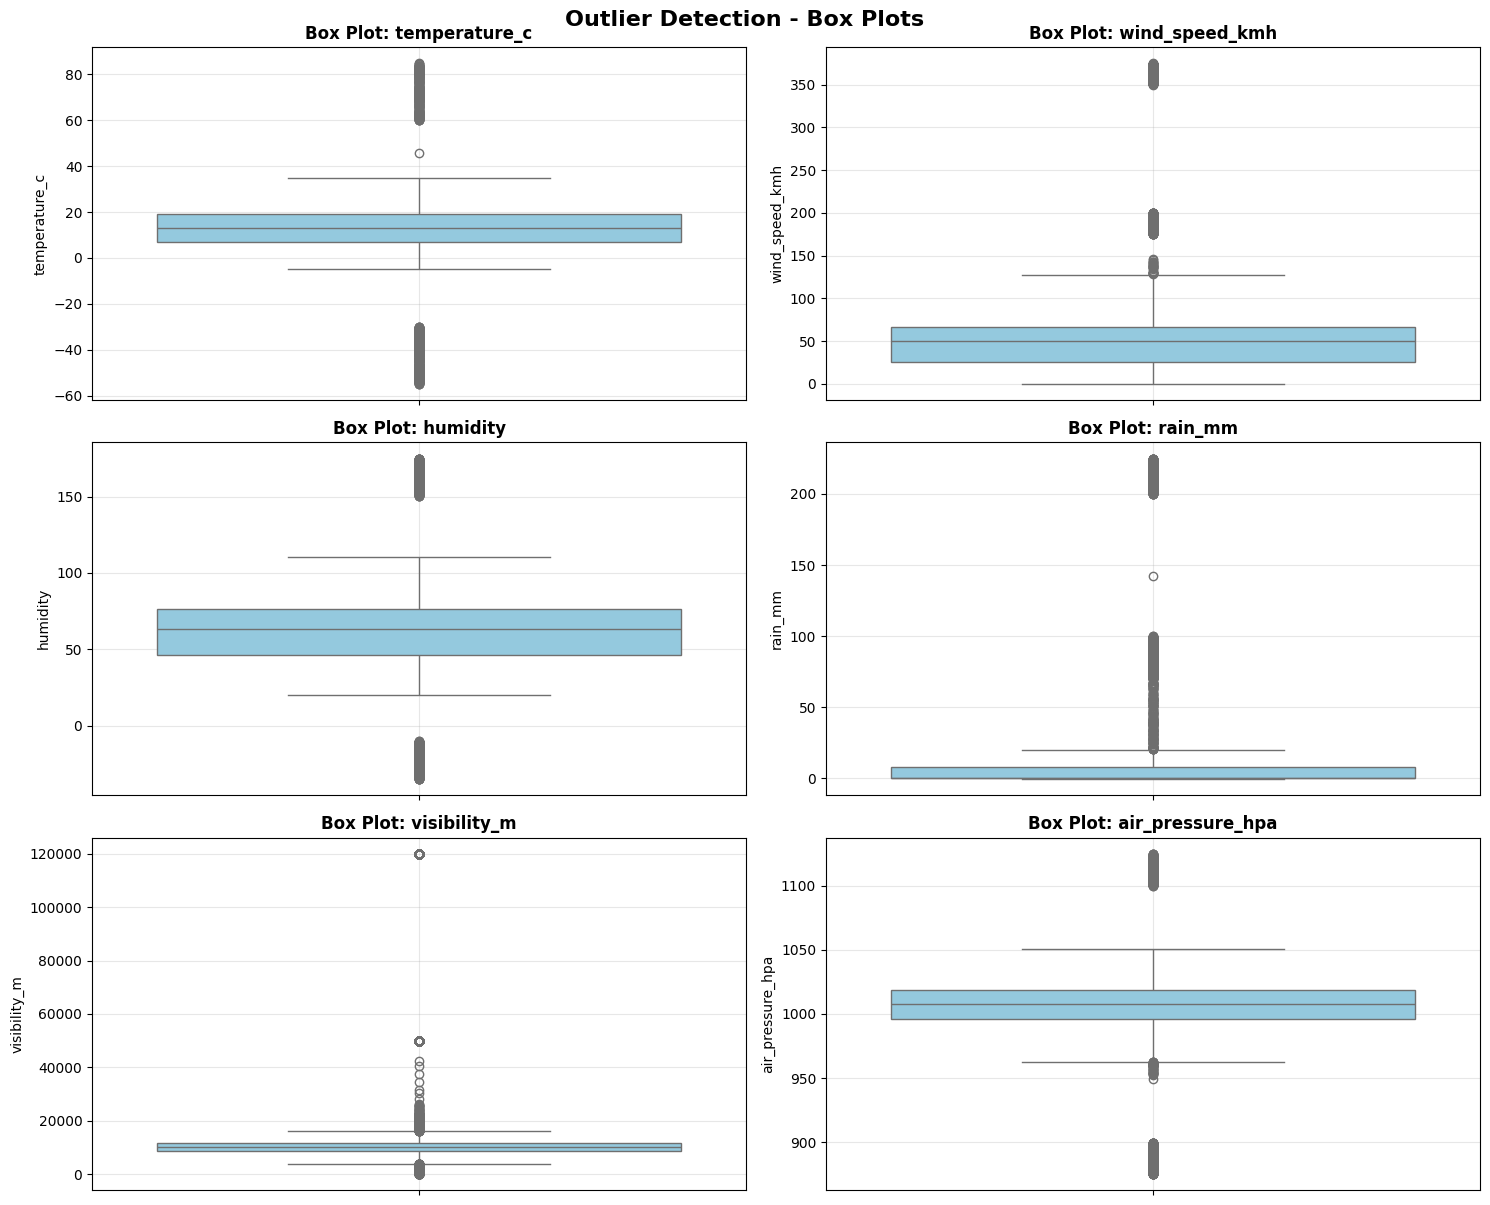

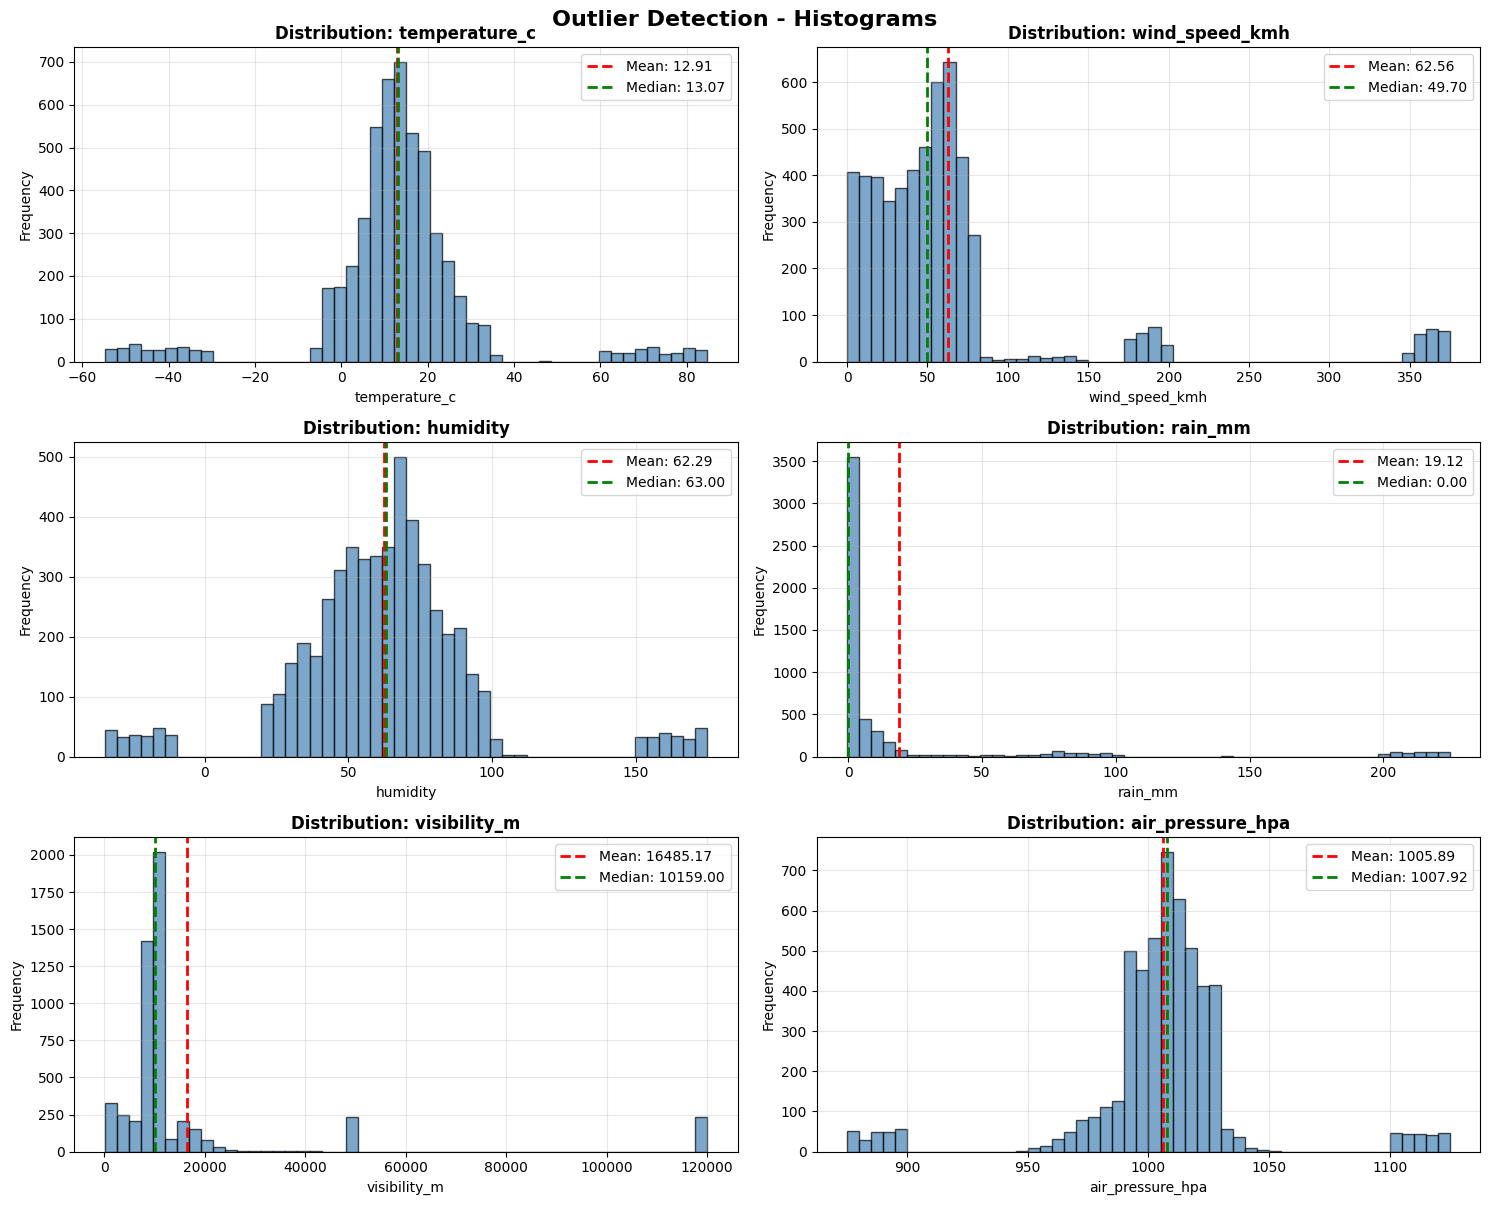

In [47]:
# Define numerical features
numerical_features = ['temperature_c', 
                     'wind_speed_kmh', 'humidity', 'rain_mm', 
                     'visibility_m', 'air_pressure_hpa']

print("="*80)
print("OUTLIER DETECTION ANALYSIS")
print("="*80)

# Statistical outlier detection using IQR and Z-score
outlier_summary = []

for col in numerical_features:
    print(f"\n{'='*80}")
    print(f"Feature: {col}")
    print(f"{'='*80}")
    
    data = df_stage_13[col].dropna()
    
    # Basic statistics
    print(f"\nBasic Statistics:")
    print(f"  Mean: {data.mean():.2f}")
    print(f"  Median: {data.median():.2f}")
    print(f"  Std Dev: {data.std():.2f}")
    print(f"  Min: {data.min():.2f}")
    print(f"  Max: {data.max():.2f}")
    
    # IQR Method
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_iqr = data[(data < lower_bound) | (data > upper_bound)]
    outlier_pct_iqr = (len(outliers_iqr) / len(data)) * 100
    
    print(f"\nIQR Method:")
    print(f"  Q1: {Q1:.2f}")
    print(f"  Q3: {Q3:.2f}")
    print(f"  IQR: {IQR:.2f}")
    print(f"  Lower Bound: {lower_bound:.2f}")
    print(f"  Upper Bound: {upper_bound:.2f}")
    print(f"  Number of Outliers: {len(outliers_iqr)} ({outlier_pct_iqr:.2f}%)")
    
    # Store summary
    outlier_summary.append({
        'Feature': col,
        'IQR_Outliers': len(outliers_iqr),
        'IQR_Percentage': outlier_pct_iqr,
        'Has_Outliers': 'Yes' if len(outliers_iqr) > 0 else 'No'
    })

# Create summary dataframe
summary_df = pd.DataFrame(outlier_summary)
print(f"\n{'='*80}")
print("OUTLIER SUMMARY")
print(f"{'='*80}\n")
print(summary_df.to_string(index=False))

# Visual Analysis
n_features = len(numerical_features)
n_cols = 2
n_rows = (n_features + 1) // 2

# 1. Box plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

for idx, col in enumerate(numerical_features):
    sns.boxplot(data=df_stage_13, y=col, ax=axes[idx], color='skyblue')
    axes[idx].set_title(f'Box Plot: {col}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(col)
    axes[idx].grid(True, alpha=0.3)

# Hide extra subplots
for idx in range(len(numerical_features), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.suptitle('Outlier Detection - Box Plots', fontsize=16, fontweight='bold', y=1.00)
plt.show()

# 2. Histograms with distribution
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

for idx, col in enumerate(numerical_features):
    data = df_stage_13[col].dropna()
    axes[idx].hist(data, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[idx].axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.2f}')
    axes[idx].axvline(data.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {data.median():.2f}')
    axes[idx].set_title(f'Distribution: {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

# Hide extra subplots
for idx in range(len(numerical_features), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.suptitle('Outlier Detection - Histograms', fontsize=16, fontweight='bold', y=1.00)
plt.show()

## Handling outliers using IQR Winsorizing method

In [48]:
# Create a copy of the dataframe
fully_cleaned_df = df_stage_13.copy()

print("="*80)
print("HANDLING OUTLIERS USING IQR WINSORIZING")
print("="*80)

# Apply IQR Winsorizing to each feature
for col in numerical_features:
    # Calculate IQR bounds
    Q1 = fully_cleaned_df[col].quantile(0.25)
    Q3 = fully_cleaned_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers before winsorizing
    outliers_lower = len(fully_cleaned_df[fully_cleaned_df[col] < lower_bound])
    outliers_upper = len(fully_cleaned_df[fully_cleaned_df[col] > upper_bound])
    total_outliers = outliers_lower + outliers_upper
    
    # Winsorize: cap values at the bounds
    fully_cleaned_df[col] = np.where(fully_cleaned_df[col] < lower_bound, 
                                     lower_bound, 
                                     fully_cleaned_df[col])
    fully_cleaned_df[col] = np.where(fully_cleaned_df[col] > upper_bound, 
                                     upper_bound, 
                                     fully_cleaned_df[col])
    
    print(f"\n{col}:")
    print(f"  Lower Bound: {lower_bound:.2f}")
    print(f"  Upper Bound: {upper_bound:.2f}")
    print(f"  Outliers capped at lower bound: {outliers_lower}")
    print(f"  Outliers capped at upper bound: {outliers_upper}")
    print(f"  Total outliers handled: {total_outliers}")

print("\n" + "="*80)
print("IQR WINSORIZING COMPLETE")
print("="*80)
print(f"\nDataframe shape: {fully_cleaned_df.shape}")
print(f"All outliers have been capped at IQR bounds")
print(f"\nFirst few rows:")
print(fully_cleaned_df[numerical_features].head())

HANDLING OUTLIERS USING IQR WINSORIZING

temperature_c:
  Lower Bound: -11.04
  Upper Bound: 37.33
  Outliers capped at lower bound: 277
  Outliers capped at upper bound: 224
  Total outliers handled: 501

wind_speed_kmh:
  Lower Bound: -36.56
  Upper Bound: 127.84
  Outliers capped at lower bound: 0
  Outliers capped at upper bound: 459
  Total outliers handled: 459

humidity:
  Lower Bound: 0.60
  Upper Bound: 121.66
  Outliers capped at lower bound: 231
  Outliers capped at upper bound: 217
  Total outliers handled: 448

rain_mm:
  Lower Bound: -12.00
  Upper Bound: 20.00
  Outliers capped at lower bound: 0
  Outliers capped at upper bound: 731
  Total outliers handled: 731

visibility_m:
  Lower Bound: 3924.88
  Upper Bound: 16285.88
  Outliers capped at lower bound: 480
  Outliers capped at upper bound: 805
  Total outliers handled: 1285

air_pressure_hpa:
  Lower Bound: 962.49
  Upper Bound: 1052.15
  Outliers capped at lower bound: 268
  Outliers capped at upper bound: 220
  Tot

## Displaying fully cleaned Data set

In [49]:
fully_cleaned_df

,weather_id,date_time,city,season,temperature_c,humidity,rain_mm,weather_condition,wind_speed_kmh,visibility_m,air_pressure_hpa
0,5001,2024-01-01 00:00:00,London,Winter,-2.210000,0.604692,15.693069,Snow,43.600000,3924.875000,1010.730000
1,5002,2024-01-01 02:00:00,London,Winter,14.460000,80.000000,4.201908,Clear,78.820000,9857.000000,1004.810000
2,5003,2024-01-01 04:00:00,London,Winter,4.250000,84.000000,0.000000,Snow,21.420000,9620.000000,996.090000
3,5004,2024-01-01 06:00:00,London,Winter,1.410000,74.000000,0.000000,Clear,54.420000,11148.000000,1007.390000
4,5005,2024-01-01 08:00:00,London,Winter,7.510000,52.000000,0.000000,Clear,66.936188,11599.000000,999.580000
...,...,...,...,...,...,...,...,...,...,...,...
5245,9531,2025-12-01 12:00:00,London,Winter,9.614634,62.000000,2.671853,Clear,127.840000,8453.000000,1022.760000
5246,9532,2025-12-01 14:00:00,London,Winter,-11.039801,29.000000,0.000000,Clear,52.210000,10410.000000,1023.470000
5247,9534,2025-12-01 18:00:00,London,Winter,-3.110000,0.604692,0.000000,Snow,70.330000,10946.243164,1016.450000
5248,9902,2025-12-02 10:00:00,London,Winter,3.550000,69.000000,4.440000,Fog,29.760000,16285.875000,1015.670000


# <hr style="height:3px; border:none; background:#4a90e2;">

## Checking that outliers are removed statitically and graphically

OUTLIER DETECTION ANALYSIS

Feature: temperature_c

Basic Statistics:
  Mean: 13.08
  Median: 13.07
  Std Dev: 10.89
  Min: -11.04
  Max: 37.33

IQR Method:
  Q1: 7.10
  Q3: 19.19
  IQR: 12.09
  Lower Bound: -11.04
  Upper Bound: 37.33
  Number of Outliers: 0 (0.00%)

Feature: wind_speed_kmh

Basic Statistics:
  Mean: 50.48
  Median: 49.70
  Std Dev: 32.87
  Min: 0.01
  Max: 127.84

IQR Method:
  Q1: 25.09
  Q3: 66.19
  IQR: 41.10
  Lower Bound: -36.56
  Upper Bound: 127.84
  Number of Outliers: 0 (0.00%)

Feature: humidity

Basic Statistics:
  Mean: 61.59
  Median: 63.00
  Std Dev: 25.21
  Min: 0.60
  Max: 121.66

IQR Method:
  Q1: 46.00
  Q3: 76.26
  IQR: 30.26
  Lower Bound: 0.60
  Upper Bound: 121.66
  Number of Outliers: 0 (0.00%)

Feature: rain_mm

Basic Statistics:
  Mean: 4.82
  Median: 0.00
  Std Dev: 7.38
  Min: -0.43
  Max: 20.00

IQR Method:
  Q1: 0.00
  Q3: 8.00
  IQR: 8.00
  Lower Bound: -12.00
  Upper Bound: 20.00
  Number of Outliers: 0 (0.00%)

Feature: visibility_m

B

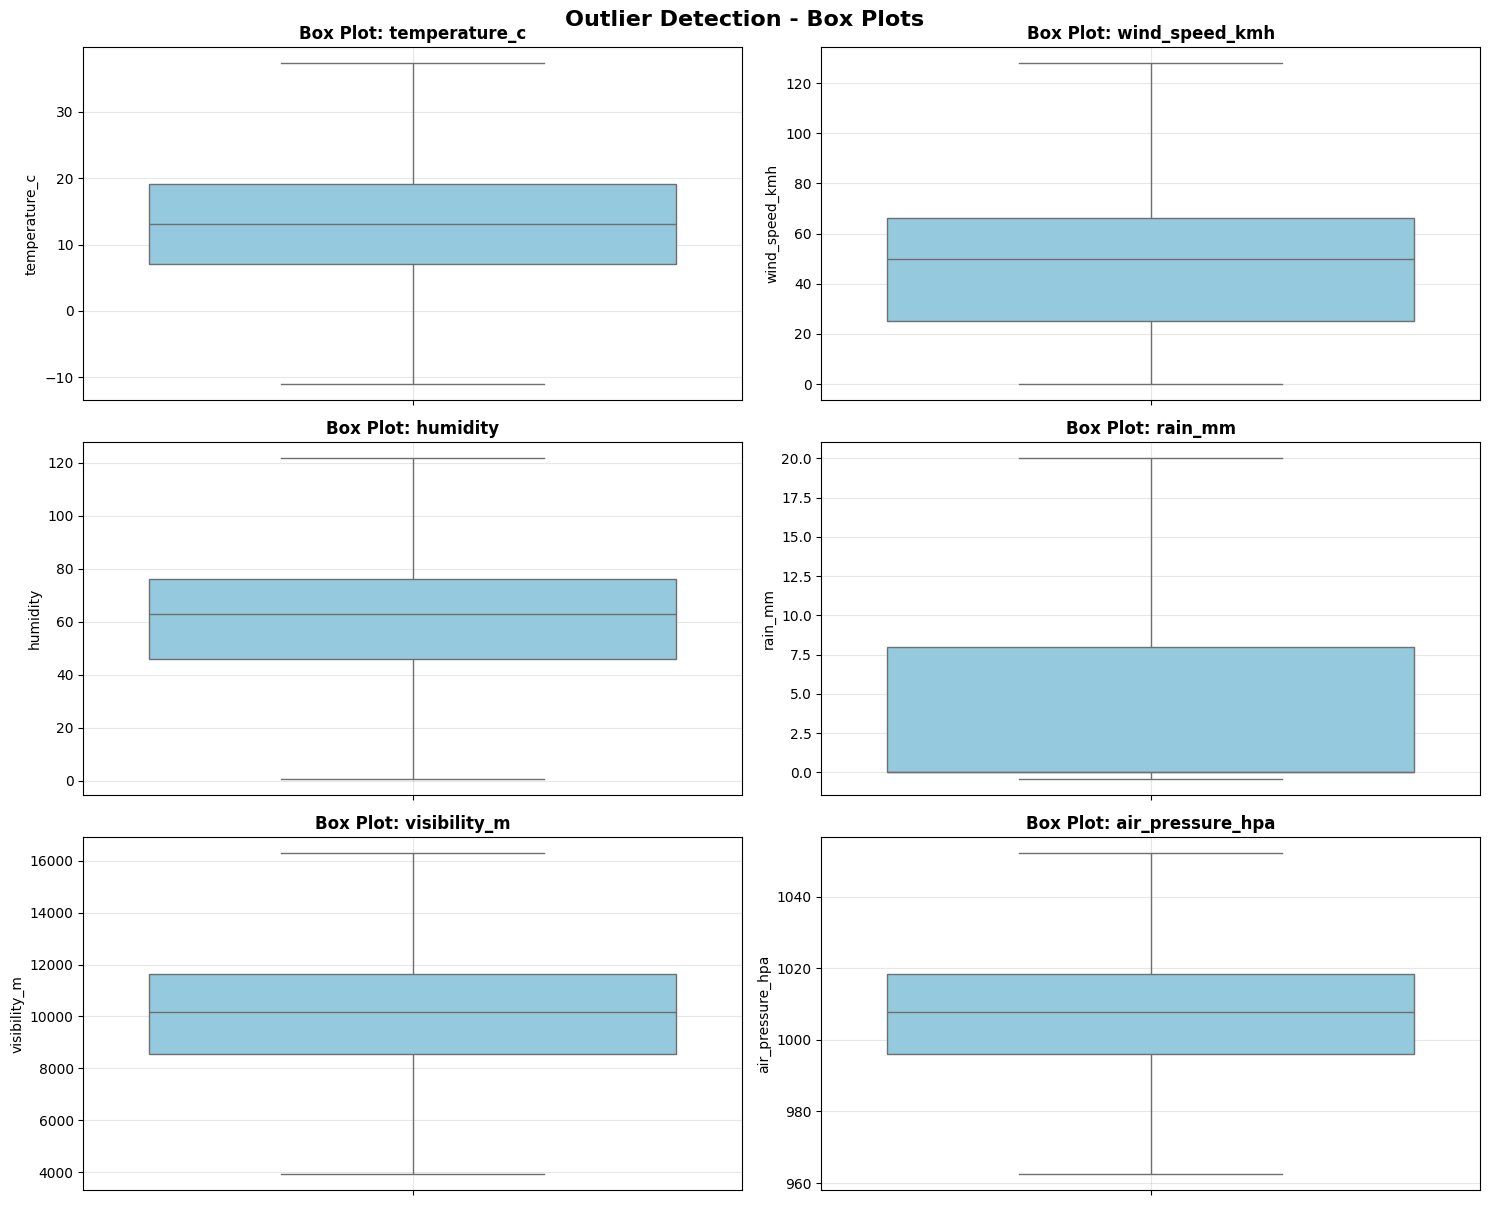

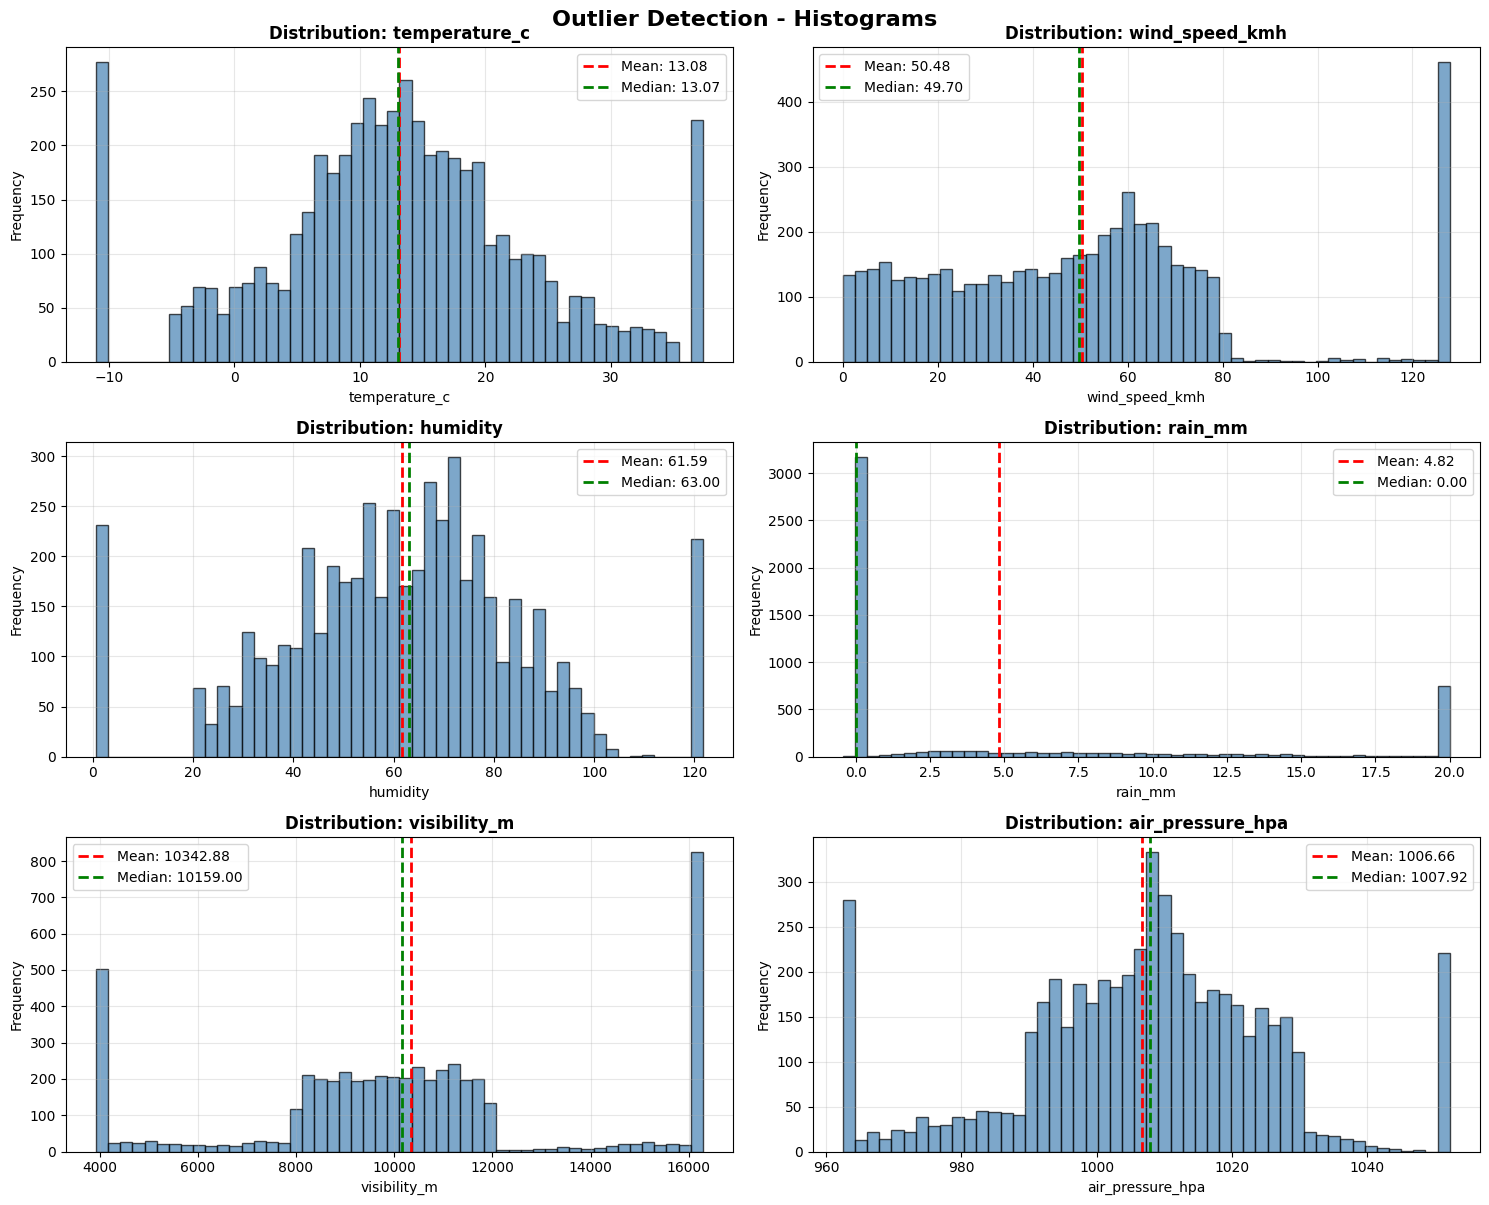

In [50]:
print("="*80)
print("OUTLIER DETECTION ANALYSIS")
print("="*80)

# Statistical outlier detection using IQR
outlier_summary = []

for col in numerical_features:
    print(f"\n{'='*80}")
    print(f"Feature: {col}")
    print(f"{'='*80}")
    
    data = fully_cleaned_df[col].dropna()
    
    # Basic statistics
    print(f"\nBasic Statistics:")
    print(f"  Mean: {data.mean():.2f}")
    print(f"  Median: {data.median():.2f}")
    print(f"  Std Dev: {data.std():.2f}")
    print(f"  Min: {data.min():.2f}")
    print(f"  Max: {data.max():.2f}")
    
    # IQR Method
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_iqr = data[(data < lower_bound) | (data > upper_bound)]
    outlier_pct_iqr = (len(outliers_iqr) / len(data)) * 100
    
    print(f"\nIQR Method:")
    print(f"  Q1: {Q1:.2f}")
    print(f"  Q3: {Q3:.2f}")
    print(f"  IQR: {IQR:.2f}")
    print(f"  Lower Bound: {lower_bound:.2f}")
    print(f"  Upper Bound: {upper_bound:.2f}")
    print(f"  Number of Outliers: {len(outliers_iqr)} ({outlier_pct_iqr:.2f}%)")
    
    # Store summary
    outlier_summary.append({
        'Feature': col,
        'IQR_Outliers': len(outliers_iqr),
        'IQR_Percentage': outlier_pct_iqr,
        'Has_Outliers': 'Yes' if len(outliers_iqr) > 0 else 'No'
    })

# Create summary dataframe
summary_df = pd.DataFrame(outlier_summary)
print(f"\n{'='*80}")
print("OUTLIER SUMMARY")
print(f"{'='*80}\n")
print(summary_df.to_string(index=False))

# Visual Analysis
n_features = len(numerical_features)
n_cols = 2
n_rows = (n_features + 1) // 2

# 1. Box plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

for idx, col in enumerate(numerical_features):
    sns.boxplot(data=fully_cleaned_df, y=col, ax=axes[idx], color='skyblue')
    axes[idx].set_title(f'Box Plot: {col}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(col)
    axes[idx].grid(True, alpha=0.3)

# Hide extra subplots
for idx in range(len(numerical_features), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.suptitle('Outlier Detection - Box Plots', fontsize=16, fontweight='bold', y=1.00)
plt.show()

# 2. Histograms with distribution
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

for idx, col in enumerate(numerical_features):
    data = fully_cleaned_df[col].dropna()
    axes[idx].hist(data, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[idx].axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.2f}')
    axes[idx].axvline(data.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {data.median():.2f}')
    axes[idx].set_title(f'Distribution: {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

# Hide extra subplots
for idx in range(len(numerical_features), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.suptitle('Outlier Detection - Histograms', fontsize=16, fontweight='bold', y=1.00)
plt.show()

# <div style="background:#f2f2f2; padding:12px; border-left:5px solid #4a90e2;">
#  <h3>📌 Data set is fully cleaned </h3>
# </div>

In [52]:
import s3fs

# 1. Save a local copy (Optional, but good for verification)
fully_cleaned_df.to_parquet("../data/cleaned/weather_cleaned.parquet", index=False, engine="pyarrow")
print("Saved locally as 'weather_cleaned.parquet'")

# 2. Save directly to MinIO Silver Bucket (Required for Phase 2)
# Define connection details for your dockerized MinIO
minio_options = {
    "key": "admin",             # From your docker-compose.yml
    "secret": "password123",    # From your docker-compose.yml
    "client_kwargs": {
        "endpoint_url": "http://localhost:9000"
    }
}

# Write to the 'silver' bucket using the s3:// protocol
try:
    fully_cleaned_df.to_parquet(
        "s3://silver/weather_cleaned.parquet", 
        storage_options=minio_options, 
        index=False
    )
    print("Success! Uploaded to MinIO Silver bucket.")
except Exception as e:
    print(f"Upload failed: {e}")

Saved locally as 'weather_cleaned.parquet'
Success! Uploaded to MinIO Silver bucket.
